In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.chdir('../')
from settings.config import Config
from src.dataset import AirbusDataset
from src.model import ResNet
from src.metrics import f2_score, vis_logs

import warnings
warnings.filterwarnings('ignore')

2023-06-14 13:39:32.444543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = ResNet().build_model()
logs = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': [],
    'f2_score': [],
    'val_f2_score': [],
    'lr': []
}

dataset = AirbusDataset()
train_ds, valid_ds = dataset.get_datasets(segmentation=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


tf.Tensor([1. 1. 0. 0.], shape=(4,), dtype=float32)


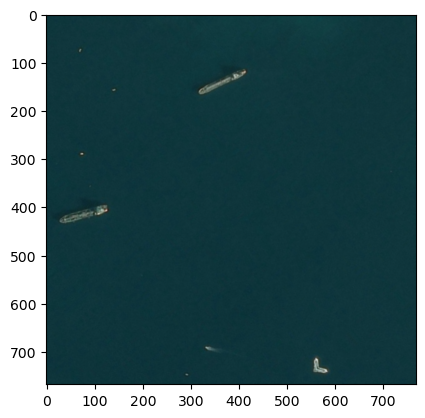

In [4]:
for batch in train_ds:
    print(batch[1])
    plt.imshow(batch[0][0])
    break

In [3]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', f2_score])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(Config.model_path, 'resnet.h5'),
    monitor='val_f2_score',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    #initial_value_threshold=0.92
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f2_score',
    factor=0.7,
    patience=3,
    mode='max',
    min_lr=1e-6
)

In [4]:
history = model.fit(train_ds, epochs=5, validation_data=valid_ds,
                    callbacks=[checkpoint, lr_scheduler])
logs = {k: logs[k] + history.history[k] for k in logs}

Epoch 1/5
3133/3133 [==============================] - 511s 147ms/step - loss: 0.5536 - accuracy: 0.7427 - f2_score: 0.8629 - val_loss: 0.4543 - val_accuracy: 0.7882 - val_f2_score: 0.8660 - lr: 0.0020
Epoch 2/5
3133/3133 [==============================] - 473s 145ms/step - loss: 0.4454 - accuracy: 0.7933 - f2_score: 0.8740 - val_loss: 0.3561 - val_accuracy: 0.8241 - val_f2_score: 0.9138 - lr: 0.0020
Epoch 3/5


In [ ]:
temp_logs = logs
temp_logs['dice_coeff'] = logs['accuracy']
temp_logs['val_dice_coeff'] = logs['val_accuracy']
vis_logs(temp_logs)

In [3]:
best_model = ResNet().build_model()
best_model.load_weights(os.path.join(Config.model_path, 'resnet.h5'))

Efforts to train the model on 256x256 images using U-Net did not yield successful results. The cropping process led to the loss of images containing crucial information such as cities, ports, and other significant features that are vital for ship classification, as they share similar visual characteristics. Training the model on 768x768 images is resource-intensive, and unfortunately, it was not possible to train the model for more than 2 epochs, resulting in limited performance. However, further improvements can be made by dedicating more efforts to address these challenges in the future.

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

preds = []
trues = []
for batch in valid_ds:
    pred = best_model(batch[0])
    preds.extend(pred.numpy().tolist())
    trues.extend(batch[1].numpy().tolist())
    
print(classification_report(trues, np.round(preds).flatten()))
confusion_matrix(trues, np.round(preds).flatten())

              precision    recall  f1-score   support

         0.0       0.84      0.49      0.62       408
         1.0       0.82      0.96      0.89       985

    accuracy                           0.82      1393
   macro avg       0.83      0.73      0.75      1393
weighted avg       0.83      0.82      0.81      1393



array([[201, 207],
       [ 38, 947]])

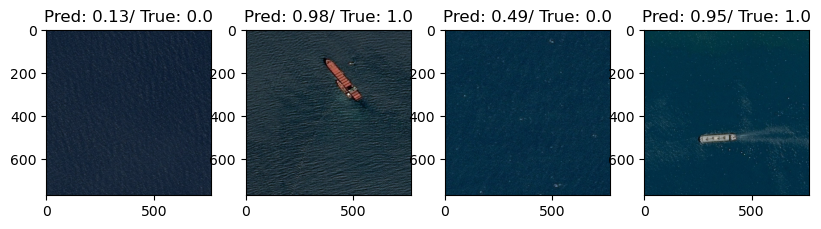

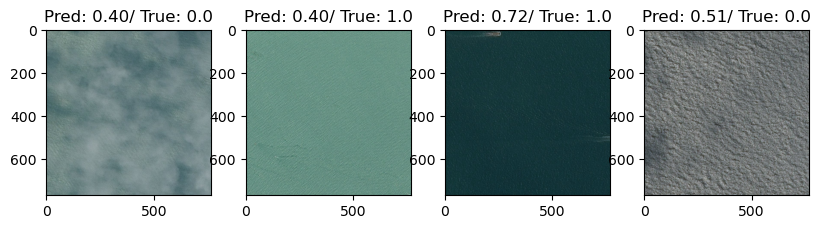

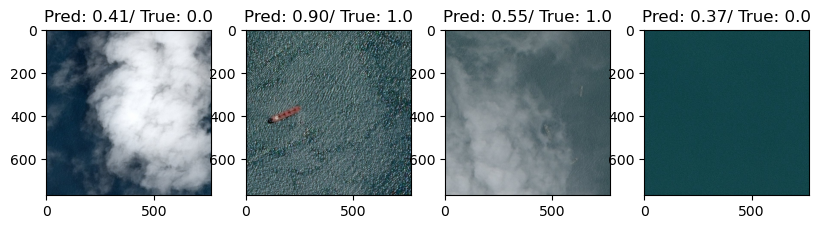

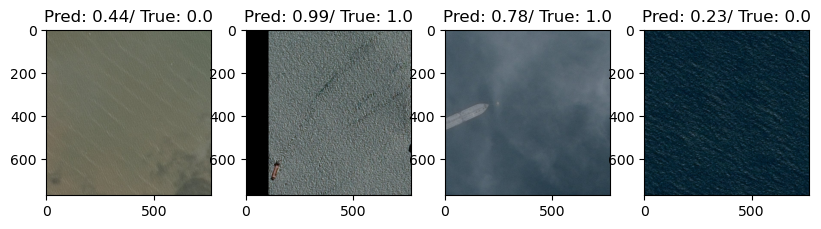

In [37]:
for j, batch in enumerate(valid_ds):
    if j == 12:
        break
    pred = best_model(batch[0])
    f2 = f2_score(batch[1], tf.cast(pred, tf.float32))
    if f2 < 2.5:
        plt.figure(figsize=(15, 15))
        for i in range(len(batch[0])):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(batch[0][i])
            pred = best_model(batch[0][i].numpy()[np.newaxis,:,:,:]).numpy()
            t = np.round(pred, 2)[0][0]
            ax.set_title(f'Pred: {t:.2f}/ True: {batch[1][i]}')
        plt.show()